# Comparing edge weight thresholds

In [1]:

import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.plot import merge_axes, soft_axis_off
from pkg.data import load_network_palette, load_unmatched
from pkg.io import FIG_PATH, get_environment_variables
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import SmartSVG, rainbowarrow, set_theme
from pkg.stats import erdos_renyi_test, stochastic_block_test
from pkg.utils import remove_group, sample_toy_networks
from scipy.interpolate import interp1d
from svgutils.compose import Figure, Panel, Text
from tqdm import tqdm
from matplotlib.patches import Circle, FancyArrowPatch

_, _, DISPLAY_FIGS = get_environment_variables()

FILENAME = "thresholding_tests"

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()

Environment variables:
   RESAVE_DATA: true
   RERUN_SIMS: true
   DISPLAY_FIGS: False



In [2]:


network_palette, NETWORK_KEY = load_network_palette()

left_adj, left_nodes = load_unmatched("left", weights=True)
right_adj, right_nodes = load_unmatched("right", weights=True)

neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "celltype_discrete"

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), gridspec_kw=dict(hspace=0))

set_theme(font_scale=1)
source_loc = (0.25, 0.5)
target_loc = (0.75, 0.5)
radius = 0.05
dim_color = "black"
dark_color = "black"


def draw_synapse_end(rad_factor, color="black"):
    rad = np.pi * rad_factor
    x = np.cos(rad)
    y = np.sin(rad)
    scale_factor = 1.6
    x *= radius * scale_factor
    y *= radius * scale_factor
    x += target_loc[0]
    y += target_loc[1]
    c = Circle((x, y), radius=0.0125, color=color)
    ax.add_patch(c)


def draw_synapse(source_loc, connection_rad=0, end_rad=0, color="black"):
    fa = FancyArrowPatch(
        posA=source_loc,
        posB=target_loc,
        connectionstyle=f"arc3,rad={connection_rad}",
        shrinkB=30,
        color=color,
    )
    ax.add_patch(fa)
    draw_synapse_end(end_rad, color=color)


def draw_neurons():
    source_circle = Circle(
        (source_loc),
        radius=radius,
        facecolor=neutral_color,
        edgecolor="black",
        linewidth=2,
        zorder=10,
    )
    ax.add_patch(source_circle)
    ax.text(*source_loc, r"$i$", zorder=11, va="center", ha="center")

    target_circle = Circle(
        (target_loc),
        radius=radius,
        facecolor=neutral_color,
        edgecolor="black",
        linewidth=2,
        zorder=10,
    )
    ax.add_patch(target_circle)
    ax.text(*target_loc, r"$j$", zorder=11, va="center", ha="center")


def set_lims(ax):
    ax.set_xlim(0.19, 0.81)
    ax.set_ylim(0.3, 0.7)


ax = axs[0]
ax.text(0.93, 0.5, 2, fontsize="large", va="center", ha="center")
soft_axis_off(ax)
ax.set_ylabel("Synapse\ncount", rotation=0, ha="right", va="center", labelpad=20)

draw_neurons()
draw_synapse(source_loc, connection_rad=-0.5, end_rad=0.75)
draw_synapse(source_loc, connection_rad=0.5, end_rad=-0.75)

set_lims(ax)

ax.annotate(
    r"Synapse from $i$ to $j$",
    (0.5, 0.63),
    xytext=(40, 25),
    textcoords="offset points",
    ha="center",
    arrowprops=dict(arrowstyle="-|>", facecolor="black", relpos=(0.25, 0)),
    fontsize="small",
)


ax = axs[1]
ax.text(0.93, 0.5, "2 / 5", fontsize="large", va="center", ha="center")
soft_axis_off(ax)
ax.set_ylabel("Input\nproportion", rotation=0, ha="right", va="center", labelpad=20)

draw_neurons()


draw_synapse(source_loc, connection_rad=-0.5, end_rad=0.75)
draw_synapse(source_loc, connection_rad=0.5, end_rad=-0.75)

dist = 0.15
draw_synapse(
    (target_loc[0], target_loc[1] + dist),
    connection_rad=0,
    end_rad=0.5,
    color=dim_color,
)
draw_synapse(
    (target_loc[0] - dist, target_loc[1]),
    connection_rad=0,
    end_rad=1,
    color=dim_color,
)
draw_synapse(
    (target_loc[0], target_loc[1] - dist),
    connection_rad=0,
    end_rad=-0.5,
    color=dim_color,
)

set_lims(ax)

ax.annotate(
    r"Synapse from not $i$ to $j$",
    (0.75, 0.4),
    xytext=(-10, -50),
    textcoords="offset points",
    ha="right",
    arrowprops=dict(arrowstyle="-|>", facecolor="black", relpos=(0.75, 1)),
    fontsize="small",
)


fig.set_facecolor("w")

fig.text(0.07, 0.89, "Weight\n type", fontsize="large", ha="right")
fig.text(0.97, 0.89, "Weight\n" + r"$i \rightarrow$ j", fontsize="large")


border_color = "lightgrey"
line1 = mpl.lines.Line2D(
    (-0.25, 1.2),
    (0.5, 0.5),
    transform=fig.transFigure,
    color=border_color,
    linewidth=1.5,
)
line2 = mpl.lines.Line2D(
    (0.95, 0.95),
    (0.15, 0.85),
    transform=fig.transFigure,
    color=border_color,
    linewidth=1.5,
)
line3 = mpl.lines.Line2D(
    (0.1, 0.1),
    (0.15, 0.85),
    transform=fig.transFigure,
    color=border_color,
    linewidth=1.5,
)

fig.lines = (line1, line2, line3)

gluefig("weight_notions", fig)

In [4]:
rng = np.random.default_rng(8888)


A1, A2, node_data = sample_toy_networks()

node_data["labels"] = np.ones(len(node_data), dtype=int)
palette = {1: sns.color_palette("Set2")[2]}

g1 = nx.from_numpy_array(A1)
g2 = nx.from_numpy_array(A2)

pos1 = nx.kamada_kawai_layout(g1)
pos2 = nx.kamada_kawai_layout(g2)


def weight_adjacency(A, scale=6):
    A = A.copy()
    sources, targets = np.nonzero(A)
    for source, target in zip(sources, targets):
        # weight = rng.poisson(scale)
        weight = rng.uniform(1, 10)
        A[source, target] = weight
    return A


def layoutplot(
    g,
    pos,
    nodes,
    ax=None,
    figsize=(10, 10),
    weight_scale=1,
    node_alpha=1,
    node_size=300,
    palette=None,
    edge_alpha=0.4,
    edge_color="black",
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    edgelist = g.edges()
    weights = np.array([g[u][v]["weight"] for u, v in edgelist])
    weights *= weight_scale

    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=nodes.index,
        node_color=nodes["labels"].map(palette),
        edgecolors="black",
        alpha=node_alpha,
        node_size=node_size,
        ax=ax,
    )

    nx.draw_networkx_edges(
        g,
        pos,
        edgelist=edgelist,
        nodelist=nodes.index,
        width=weights,
        edge_vmin=-3,
        edge_vmax=9,
        edge_color=weights,
        alpha=edge_alpha,
        ax=ax,
        node_size=node_size,
    )

    soft_axis_off(ax)

    return ax


set_theme(font_scale=1.75)

fig, axs = plt.subplots(
    4,
    3,
    figsize=(12, 10),
    constrained_layout=True,
    gridspec_kw=dict(height_ratios=[0.5, 1, 0.25, 1], hspace=0, wspace=0),
)
A1 = weight_adjacency(A1)
A2 = weight_adjacency(A2)
kwargs = dict(
    palette=palette, edge_alpha=1, edge_color=(0.65, 0.65, 0.65), weight_scale=0.75
)
thresholds = [1, 4, 7]
for i in range(3):
    A1[A1 < thresholds[i]] = 0
    A2[A2 < thresholds[i]] = 0
    g1 = nx.from_numpy_array(A1)
    g2 = nx.from_numpy_array(A2)

    ax = axs[1, i]
    layoutplot(g1, pos1, node_data, ax=ax, **kwargs)
    ax = axs[3, i]
    layoutplot(g2, pos2, node_data, ax=ax, **kwargs)


ax = merge_axes(fig, axs, rows=0)

rainbowarrow(ax, start=(0.1, 0.5), end=(0.9, 0.5), cmap="Greys", n=1000, lw=30)
ax.set(ylim=(0.4, 0.8), xlim=(0, 1))
ax.set_title("Increasing edge weight threshold", fontsize="large", y=0.5)
ax.axis("off")


def draw_comparison(ax):
    ax.text(
        0.48, 0.35, r"$\overset{?}{=}$", fontsize="xx-large", ha="center", va="center"
    )
    ax.set(ylim=(0, 1), xlim=(0, 1))
    ax.axis("off")


ax = axs[2, 0]
draw_comparison(ax)

ax = axs[2, 1]
draw_comparison(ax)

ax = axs[2, 2]
draw_comparison(ax)

ax.annotate(
    "Rerun all\n tests",
    (0.6, 0.6),
    xytext=(45, 0),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="-|>", facecolor="black"),
    fontsize="medium",
    va="center",
)

axs[1, 0].set_ylabel(
    "Left",
    color=network_palette["Left"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

axs[3, 0].set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

fig.set_facecolor("w")

gluefig("thresholding_methods", fig)

In [5]:


def construct_weight_data(left_adj, right_adj):
    indices = np.nonzero(left_adj)
    left_weights = left_adj[indices]

    indices = np.nonzero(right_adj)
    right_weights = right_adj[indices]

    labels = np.concatenate(
        (len(left_weights) * ["Left"], len(right_weights) * ["Right"])
    )
    weights = np.concatenate((left_weights, right_weights))
    weight_data = pd.Series(data=weights, name="weights").to_frame()
    weight_data["labels"] = labels
    return weight_data


weight_data = construct_weight_data(left_adj, right_adj)
weight_data = weight_data[weight_data["weights"] < 10]


set_theme(font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.histplot(
    data=weight_data,
    x="weights",
    hue="labels",
    palette=network_palette,
    ax=ax,
    discrete=True,
    cumulative=False,
)
sns.move_legend(ax, loc="upper right", title="Hemisphere")
ax.set(xlabel="Weight (synapse count)")
ax.set(xticks=np.arange(1, 10))
ax.set_yscale("log")

gluefig("synapse_weight_histogram", fig)

In [6]:

d_key = "Density"
gc_key = "Group connection"
dagc_key = "Density-adjusted\ngroup connection"


def binarize(A, threshold=None):
    # threshold is the smallest that is kept

    B = A.copy()

    if threshold is not None:
        B[B < threshold] = 0

    return B


rows = []
thresholds = np.arange(1, 10)
for threshold in tqdm(thresholds):
    left_adj_thresh = binarize(left_adj, threshold=threshold)
    right_adj_thresh = binarize(right_adj, threshold=threshold)

    p_edges_removed = 1 - (
        np.count_nonzero(left_adj_thresh) + np.count_nonzero(right_adj_thresh)
    ) / (np.count_nonzero(left_adj) + np.count_nonzero(right_adj))

    stat, pvalue, misc = erdos_renyi_test(left_adj_thresh, right_adj_thresh)
    row = {
        "threshold": threshold,
        "stat": stat,
        "pvalue": pvalue,
        "method": d_key,
        "p_edges_removed": p_edges_removed,
    }
    rows.append(row)

    for adjusted in [False, True]:
        if adjusted:
            method = dagc_key
        else:
            method = gc_key
        stat, pvalue, misc = stochastic_block_test(
            left_adj_thresh,
            right_adj_thresh,
            left_labels,
            right_labels,
            density_adjustment=adjusted,
        )
        row = {
            "threshold": threshold,
            "adjusted": adjusted,
            "stat": stat,
            "pvalue": pvalue,
            "method": method,
            "p_edges_removed": p_edges_removed,
        }
        rows.append(row)

integer_results = pd.DataFrame(rows)

100%|██████████████████████████████████████████████████████████████████████| 9/9 [00:24<00:00,  2.69s/it]


In [7]:


def add_alpha_line(ax):
    ax.axhline(0.05, color="black", linestyle=":", zorder=-1)
    ax.annotate(
        r"0.05",
        (ax.get_xlim()[0], 0.05),
        xytext=(-45, -15),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-", color="black"),
        clip_on=False,
        ha="right",
    )

In [8]:


def plot_thresholding_pvalues(
    results, weight, figsize=(8, 6), no_reject_x=None, reject_x=None
):
    set_theme(font_scale=1.25)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    colors = sns.color_palette("tab20")
    palette = dict(zip([gc_key, dagc_key, d_key], [colors[0], colors[1], colors[12]]))

    sns.scatterplot(
        data=results,
        x="p_edges_removed",
        y="pvalue",
        hue="method",
        palette=palette,
        ax=ax,
        legend=True,
    )
    sns.lineplot(
        data=results,
        x="p_edges_removed",
        y="pvalue",
        hue="method",
        palette=palette,
        ax=ax,
        legend=False,
    )

    ax.set(
        yscale="log",
        ylabel="p-value",
        xlabel="Edges removed",
        yticks=np.geomspace(1, 1e-20, 5),
    )

    # just pick any method because these are the same for each
    single_results = results[results["method"] == "Density"]
    x = single_results["p_edges_removed"]
    y = single_results["threshold"]

    ax.set_xlim((x.min(), x.max()))
    ax.tick_params(axis="both", length=5)
    ax.set_xticks([0, 0.25, 0.5, 0.75])
    ax.set_xticklabels(["0%", "25%", "50%", "75%"])

    # basically fitting splines to interpolate linearly between points we checked
    prop_to_thresh = interp1d(
        x=x, y=y, kind="slinear", bounds_error=False, fill_value=(0, 1)
    )
    thresh_to_prop = interp1d(
        x=y, y=x, kind="slinear", bounds_error=False, fill_value=(0, 1)
    )

    ax2 = ax.secondary_xaxis(-0.2, functions=(prop_to_thresh, thresh_to_prop))

    if weight == "input_proportion":
        ax2.set_xticks([0.005, 0.01, 0.015, 0.02])
        ax2.set_xticklabels(["0.5%", "1%", "1.5%", "2%"])
        ax2.set_xlabel("Weight threshold (input percentage)")
    elif weight == "synapse_count":
        ax2.set_xlabel("Weight threshold (synapse count)")
    ax2.tick_params(axis="both", length=5)

    add_alpha_line(ax)

    sns.move_legend(
        ax,
        "lower left",
        title="Test",
        frameon=True,
        fontsize="small",
        ncol=1,
        labelspacing=0.3,
    )

    # shading
    ax.autoscale(False)
    if no_reject_x is None:
        no_reject_x = ax.get_xlim()[1]
    ax.fill_between(
        (ax.get_xlim()[0], no_reject_x),
        y1=0.05,
        y2=ax.get_ylim()[0],
        color="darkred",
        alpha=0.05,
    )

    if reject_x is None:
        reject_x = np.mean(ax.get_xlim())

    y = np.mean(np.sqrt(np.product(ax.get_ylim())))
    ax.text(
        reject_x,
        y,
        "Reject\nsymmetry",
        ha="center",
        va="center",
        color="darkred",
    )

    return fig, ax

In [9]:
fig, ax = plot_thresholding_pvalues(integer_results, "synapse_count")
gluefig("synapse_threshold_pvalues_legend", fig)
ax.get_legend().remove()
gluefig("synapse_threshold_pvalues", fig)

In [10]:
### EDGE WEIGHTS AS INPUT PROPORTIONS

In [11]:
left_input = (left_nodes["axon_input"] + left_nodes["dendrite_input"]).values
left_input[left_input == 0] = 1
left_adj_input_norm = left_adj / left_input[None, :]

right_input = (right_nodes["axon_input"] + right_nodes["dendrite_input"]).values
right_input[right_input == 0] = 1
right_adj_input_norm = right_adj / right_input[None, :]

In [12]:

rows = []
thresholds = np.linspace(0, 0.03, 31)
for threshold in tqdm(thresholds):
    left_adj_thresh = binarize(left_adj_input_norm, threshold=threshold)
    right_adj_thresh = binarize(right_adj_input_norm, threshold=threshold)

    p_edges_removed = 1 - (
        np.count_nonzero(left_adj_thresh) + np.count_nonzero(right_adj_thresh)
    ) / (np.count_nonzero(left_adj) + np.count_nonzero(right_adj))

    stat, pvalue, misc = erdos_renyi_test(left_adj_thresh, right_adj_thresh)
    row = {
        "threshold": threshold,
        "stat": stat,
        "pvalue": pvalue,
        "method": d_key,
        "p_edges_removed": p_edges_removed,
    }
    rows.append(row)

    for adjusted in [False, True]:
        if adjusted:
            method = dagc_key
        else:
            method = gc_key
        stat, pvalue, misc = stochastic_block_test(
            left_adj_thresh,
            right_adj_thresh,
            left_labels,
            right_labels,
            density_adjustment=adjusted,
        )
        row = {
            "threshold": threshold,
            "adjusted": adjusted,
            "stat": stat,
            "pvalue": pvalue,
            "method": method,
            "p_edges_removed": p_edges_removed,
        }
        rows.append(row)
input_results = pd.DataFrame(rows)

100%|████████████████████████████████████████████████████████████████████| 31/31 [02:18<00:00,  4.46s/it]


In [13]:


x = input_results[input_results["method"] == "Density"].iloc[12]["p_edges_removed"]
x_threshold = input_results[input_results["method"] == "Density"].iloc[12]["threshold"]

fig, ax = plot_thresholding_pvalues(
    input_results, "input_proportion", no_reject_x=x, reject_x=np.mean((0, x))
)

ax.axvline(
    x,
    ax.get_ylim()[0],
    0.95,
    color="black",
    linestyle="--",
    zorder=0,
)
ax.text(
    x + 0.005,
    np.mean(np.sqrt(np.product(ax.get_ylim()))),
    r"$\rightarrow$"
    + "\n\n\n  All tests fail to\n  reject symmetry\n\n\n"
    + r"$\rightarrow$",
    ha="left",
    va="center",
)

gluefig("input_threshold_pvalues_legend", fig)
ax.get_legend().remove()
gluefig("input_threshold_pvalues", fig)

In [14]:
# Look at histogram

In [15]:

weight_data = construct_weight_data(left_adj_input_norm, right_adj_input_norm)
median = np.median(weight_data["weights"])

set_theme(font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.histplot(
    data=weight_data,
    x="weights",
    hue="labels",
    palette=network_palette,
    ax=ax,
    discrete=False,
    cumulative=False,
    common_norm=True,
    log_scale=True,
    stat="count",
    bins=50,
    kde=True,
)
sns.move_legend(ax, loc="upper right", title="Hemisphere")
ax.set(xlabel="Weight (input percentage)")
ax.set_xticks([1e-3, 1e-2, 1e-1, 1])
ax.set_xticklabels(["0.1%", "1%", "10%", "100%"])
ax.set_yticks([1000, 2000])
ax.tick_params(pad=10)
ax.axvline(x_threshold, 0, 0.99, color="black", linestyle="--", linewidth=4, alpha=1)
ax.annotate(
    "Critical point\n(Panel F)",
    (x_threshold, ax.get_ylim()[1] * 0.95),
    xytext=(-50, 10),
    textcoords="offset points",
    ha="right",
    va="top",
    color="black",
    arrowprops=dict(arrowstyle="-|>", facecolor="black", relpos=(1, 0.7)),
)
gluefig("input_proportion_histogram", fig)

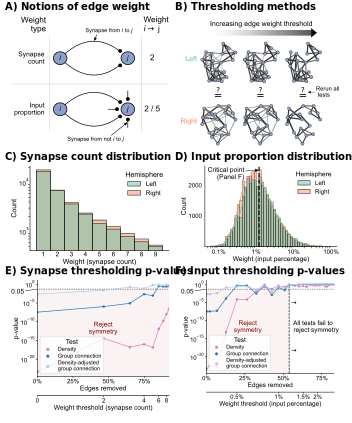

In [16]:
fontsize = 10

weight_notions = SmartSVG(FIG_PATH / "weight_notions.svg")
weight_notions.set_width(200)
weight_notions.move(10, 15)
weight_notions_panel = Panel(
    weight_notions,
    Text("A) Notions of edge weight", 5, 10, size=fontsize, weight="bold"),
)

methods = SmartSVG(FIG_PATH / "thresholding_methods.svg")
methods.set_width(200)
methods.move(10, 15)
methods_panel = Panel(
    methods, Text("B) Thresholding methods", 5, 10, size=fontsize, weight="bold")
)
methods_panel.move(weight_notions.width * 0.85, 0)

synapse_hist = SmartSVG(FIG_PATH / "synapse_weight_histogram.svg")
synapse_hist.set_width(200)
synapse_hist.move(10, 15)
synapse_hist_panel = Panel(
    synapse_hist,
    Text("C) Synapse count distribution", 5, 10, size=fontsize, weight="bold"),
)
synapse_hist_panel.move(0, methods.height * 0.9)

input_hist = SmartSVG(FIG_PATH / "input_proportion_histogram.svg")
input_hist.set_width(200)
input_hist.move(10, 15)
input_hist_panel = Panel(
    input_hist,
    Text("D) Input proportion distribution", 5, 10, size=fontsize, weight="bold"),
)
input_hist_panel.move(synapse_hist.width * 0.85, methods.height * 0.9)

synapse_pvalues = SmartSVG(FIG_PATH / "synapse_threshold_pvalues_legend.svg")
synapse_pvalues.set_width(200)
synapse_pvalues.move(10, 15)
synapse_pvalues_panel = Panel(
    synapse_pvalues,
    Text("E) Synapse thresholding p-values", 5, 10, size=fontsize, weight="bold"),
)
synapse_pvalues_panel.move(0, (methods.height + synapse_hist.height) * 0.9)

input_pvalues = SmartSVG(FIG_PATH / "input_threshold_pvalues_legend.svg")
input_pvalues.set_width(200)
input_pvalues.move(10, 15)
input_pvalues_panel = Panel(
    input_pvalues,
    Text("F) Input thresholding p-values", 5, 10, size=fontsize, weight="bold"),
)
input_pvalues_panel.move(
    synapse_pvalues.width * 0.85, (methods.height + synapse_hist.height) * 0.9
)

fig = Figure(
    methods.width * 2 * 0.88,
    (methods.height + synapse_hist.height + synapse_pvalues.height) * 0.92,
    weight_notions_panel,
    methods_panel,
    synapse_hist_panel,
    input_hist_panel,
    synapse_pvalues_panel,
    input_pvalues_panel,
)
fig.save(FIG_PATH / "thresholding_composite.svg")
fig

In [17]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:02:56.661383
Completed at 2022-09-26 09:54:36.673426


In [18]:


(
    left_adj_input_norm_sub,
    right_adj_input_norm_sub,
    left_nodes_sub,
    right_nodes_sub,
) = remove_group(
    left_adj_input_norm, right_adj_input_norm, left_nodes, right_nodes, "KCs"
)


weight_data = construct_weight_data(left_adj_input_norm_sub, right_adj_input_norm_sub)
median = np.median(weight_data["weights"])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(
    data=weight_data,
    x="weights",
    hue="labels",
    palette=network_palette,
    ax=ax,
    discrete=False,
    cumulative=False,
    common_norm=True,
    log_scale=True,
    stat="count",
    bins=50,
    kde=True,
)
sns.move_legend(ax, loc="upper right", title="Hemisphere")
ax.set(xlabel="Weight (input proportion)")
ax.axvline(x_threshold, color="black", linestyle="--", linewidth=4, alpha=1)

ax.set_title("KC-")
gluefig("input_proportion_histogram_kc_minus", fig)